In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os


In [2]:
#dataset
class BMIDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform = None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.annotations)
    def __getitem__(self,idx
                    ):
        img_path = self.annotations.iloc[idx, 5]
        image = Image.open(img_path).convert("RGB")
        bmi_label = float(self.annotations.iloc[idx, 4])

        if self.transform:
            image = self.transform(image)

        return (image, bmi_label)
    

In [3]:
resize = 224

In [4]:
transform = transforms.Compose([
    transforms.Resize((resize, resize)),  # Chọn kích thước ảnh sau khi augment
    transforms.ToTensor(),  # Chuyển ảnh sang tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Chuẩn hóa tensor
])

In [5]:
transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)

In [6]:
class BMIModel(nn.Module):
    def __init__(self):
        super(BMIModel,self).__init__()
        self.conv1 = nn.Conv2d(3,6, 3) #224x224
        self.relu1 = nn.ReLU()
        self.batch1 = nn.BatchNorm2d(6)
        self.pool1 = nn.MaxPool2d( 2,2) #111x111
        
        self.conv2 = nn.Conv2d(6 ,10 , 3) # 110 x110
        self.relu2 = nn.ReLU()
        self.batch2 = nn.BatchNorm2d(10)
        self.pool2 = nn.MaxPool2d( 2,2)# 55x55
        
        self.l_conv1 = int((224- 3) + 1)
        self.l_maxpool1= int((self.l_conv1 - 2)/2 + 1)

        self.l_conv2 = int((self.l_maxpool1- 3) + 1)
        self.l_maxpool2= int((self.l_conv2 - 2)/2 + 1)        
        self.linear = nn.Linear(self.l_maxpool2*self.l_maxpool2*10,1)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.batch1(x)
        x = self.pool1(x)
        
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.batch2(x)
        x = self.pool2(x)
        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)
        
        return x

In [7]:
dataset = BMIDataset(csv_file ='/home/quanhhh/Documents/pre_bmi/pr_databmi.csv',
                     root_dir = '/home/quanhhh/Documents/vip/vip/data/data/',
                     transform = transform )

In [8]:
annotations = pd.read_csv('/home/quanhhh/Documents/pre_bmi/pr_databmi.csv')
img_path = annotations.iloc[ : , 5]
img_path

0       /home/quanhhh/Documents/vip/vip/data/data/f_00...
1       /home/quanhhh/Documents/vip/vip/data/data/f_00...
2       /home/quanhhh/Documents/vip/vip/data/data/f_00...
3       /home/quanhhh/Documents/vip/vip/data/data/f_00...
4       /home/quanhhh/Documents/vip/vip/data/data/f_00...
                              ...                        
1021    /home/quanhhh/Documents/vip/vip/data/data/m_50...
1022    /home/quanhhh/Documents/vip/vip/data/data/m_51...
1023    /home/quanhhh/Documents/vip/vip/data/data/m_51...
1024    /home/quanhhh/Documents/vip/vip/data/data/m_51...
1025    /home/quanhhh/Documents/vip/vip/data/data/m_51...
Name: path, Length: 1026, dtype: object

In [9]:
#set up data loader and transformations
total_samples = len(dataset)
total_samples
from torch.utils.data import random_split
total_samples = len(dataset)
train_size = int(0.7 * total_samples)  # Adjust the split ratio as needed
test_size = total_samples - train_size

train_set, test_set = random_split(dataset, [train_size, test_size])

In [10]:
batch_size = 226


In [11]:
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size= 308, shuffle=True)



In [12]:
model = BMIModel()


In [13]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [14]:
criterion = RMSELoss()  # Root Mean Squared Error Loss for regression tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [15]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [16]:


#create variable to tracks things
num_epochs = 25

losses = []

n_total_steps = len(train_loader)
#For Loop of epochs
for epoch in range(num_epochs):
   
    
    #train
   
    for i, (image, bmi_labels) in enumerate(train_loader):
        
    
        y_pred = model(image)
        loss = criterion(y_pred, bmi_labels.view(-1, 1).float())/len(train_loader)
        losses.append(loss)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #if(i+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
print("finish training")

Epoch [1/25], Step [1/4], Loss: 5.7715
Epoch [1/25], Step [2/4], Loss: 3.2801
Epoch [1/25], Step [3/4], Loss: 2.1537
Epoch [1/25], Step [4/4], Loss: 2.8861
Epoch [2/25], Step [1/4], Loss: 2.6502
Epoch [2/25], Step [2/4], Loss: 2.3831
Epoch [2/25], Step [3/4], Loss: 2.4365
Epoch [2/25], Step [4/4], Loss: 2.2487
Epoch [3/25], Step [1/4], Loss: 1.8850
Epoch [3/25], Step [2/4], Loss: 1.6613
Epoch [3/25], Step [3/4], Loss: 1.5674
Epoch [3/25], Step [4/4], Loss: 1.4600
Epoch [4/25], Step [1/4], Loss: 1.4531
Epoch [4/25], Step [2/4], Loss: 1.7089
Epoch [4/25], Step [3/4], Loss: 1.5097
Epoch [4/25], Step [4/4], Loss: 1.4490
Epoch [5/25], Step [1/4], Loss: 1.4221
Epoch [5/25], Step [2/4], Loss: 1.2237
Epoch [5/25], Step [3/4], Loss: 1.3352
Epoch [5/25], Step [4/4], Loss: 1.1293
Epoch [6/25], Step [1/4], Loss: 1.3070
Epoch [6/25], Step [2/4], Loss: 1.1024
Epoch [6/25], Step [3/4], Loss: 1.2517
Epoch [6/25], Step [4/4], Loss: 0.9525
Epoch [7/25], Step [1/4], Loss: 1.0377
Epoch [7/25], Step [2/4],

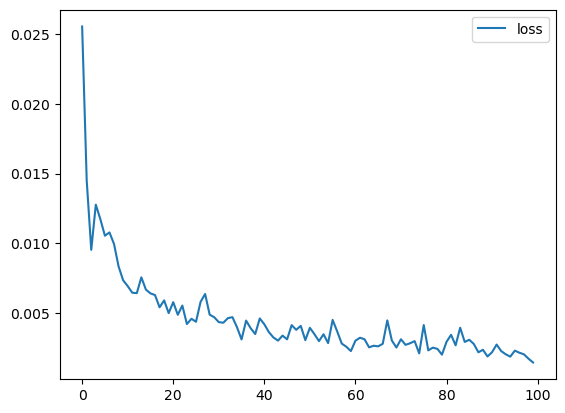

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
losses = [tl.item() for tl in losses]
plt.plot( [t /226 for t in losses ], label = "loss")

plt.legend()
          

In [18]:
test_loss = 0.0
test_score = 0.0
test_loss_list = []
pred_list = []
truth_list = []
label_list = []
score_list = []


In [19]:
from sklearn.metrics import mean_absolute_error
losses_ = []
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, bmi_labels in test_loader:
        # Assuming your model takes images as input
        bmi_out = model(images)
        loss_ = criterion(bmi_out, bmi_labels.view(-1, 1).float())/len(train_loader)
        losses_.append(loss)
        bmi_out = pd.DataFrame(bmi_out)
        print(bmi_out)
        bmi_labels = pd.DataFrame(bmi_labels)
        print(bmi_labels)
        
# Compute accuracy
   
    score = mean_absolute_error(bmi_labels, bmi_out)
    print("The Mean Absolute Error of our Model is {}".format(round(score, 2)))

             0
0    26.750422
1    21.777269
2    21.035004
3    17.303625
4    23.314848
..         ...
303  25.244642
304  26.525419
305  25.965702
306  21.031630
307  20.932478

[308 rows x 1 columns]
             0
0    26.874496
1    26.699893
2    24.489796
3    22.917610
4    24.964946
..         ...
303  26.023049
304  26.827421
305  26.173833
306  23.374726
307  20.964361

[308 rows x 1 columns]
The Mean Absolute Error of our Model is 4.03


In [20]:
def train():
    # train_epoch
    # test_epoch
    # luu model/ tra ve model
    # self.best_model = copy.deepcopy(self.model)
    pass




In [40]:
with torch.no_grad():
    image = Image.open('a.jpg').convert("RGB")
   
    image = transform(image)
    image = image.unsqueeze_(0)
    #y =image.size()
    y = model(image)

    print(y)

tensor([[25.3458]])
